In [102]:
import numpy as np
from scipy import *
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from xppcall import xpprun
import networkx as nx
import conley_functions as cf
import subprocess
from scipy.optimize import fsolve

In [182]:
delta = 1
epsilon = 0.4
#check legal:
print(epsilon<delta/(1+delta))
N=2
# W = -2*np.ones((N,N))
wi=-1-delta
we=-1+epsilon
W = np.array([[0,we],
              [we,0]])
# W = np.array([[0,we,wi],
#               [wi,0,we],
#               [we,wi,0]])
# W = np.array([[0,we,wi,wi],
#               [wi,0,wi,we],
#               [wi,we,0,wi],
#               [we,wi,we,0]])
# W = np.array([[0,wi,we,we,wi],
#               [we,0,wi,we,wi],
#               [wi,we,0,wi,wi],
#               [wi,wi,wi,0,we],
#               [wi,we,wi,wi,0]])
# W = np.array([[0,we,wi,we,wi],
#               [wi,0,wi,wi,we],
#               [wi,we,0,we,wi],
#               [wi,wi,wi,0,we],
#               [we,wi,we,wi,0]]).T
bs = np.ones(N)
dt=0.1
wcstring = cf.make_ctln(W, bs, dt=dt)
with open('ctln_p.ode', 'w') as f:
    f.writelines(wcstring)

True


In [183]:
W

array([[ 0. , -0.6],
       [-0.6,  0. ]])

In [184]:
func = lambda x : np.dot(W,x)-x+bs
tau_initial_guess = [0.5]*2
tau_solution = fsolve(func, tau_initial_guess)

In [185]:
tau_solution

array([0.625, 0.625])

In [186]:
for i,init in enumerate([0.2777, 0.2777, 0.2777]):
    inits_dict['x'+str(i+1)]=init
npa, vn = xpprun('ctln_p.ode', inits=inits_dict, parameters={'total':10}, clean_after=True)

<IPython.core.display.Javascript object>


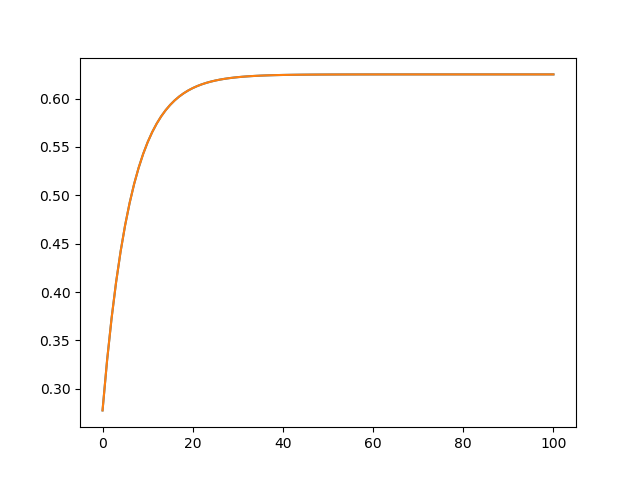

In [187]:
%matplotlib notebook
plt.plot(npa[:,1:])

<IPython.core.display.Javascript object>


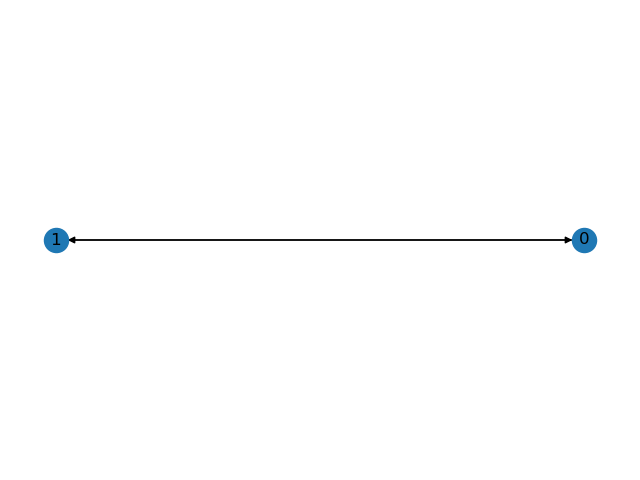

array([[0, 1],
       [1, 0]])

In [166]:
%matplotlib notebook

G=nx.from_numpy_matrix(np.where(np.logical_and(W>-1,W<0),1,0).T,create_using=nx.DiGraph())
nx.draw_circular(G, with_labels=True)
np.where(np.logical_and(W>-1,W<0),1,0).T

In [188]:
low=0;high=1;delta=.25
grid = cf.make_grid(N, low, high, delta)

In [189]:
len(grid)

25

In [190]:
%matplotlib notebook
time = 500
data = np.array([[0]*N])
data_length_list = []
for gc in grid:
    inits_dict={}
    for i,init in enumerate(gc):
        inits_dict['x'+str(i+1)]=init
    npa, vn = xpprun('ctln_p.ode', inits=inits_dict, parameters={'total':time}, clean_after=True)
    data = np.append(data, npa[:,1:], axis=0)  
    data_length_list.append(npa.shape[0])
#     plt.plot(npa[:,1])
data = data[1:,:]

In [191]:
# %matplotlib notebook

# plt.plot(data.reshape(len(grid), 10*time+1, N)[:,:,1], data.reshape(len(grid), 10*time+1, N)[:,:,2])

In [192]:
rd=data.reshape(len(grid),-1,2)
rd.shape

(25, 5001, 2)

<IPython.core.display.Javascript object>


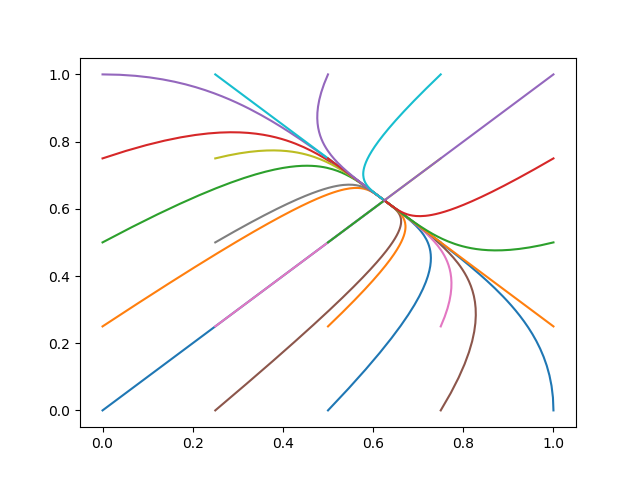

In [193]:
%matplotlib notebook
for i in range(25):
    plt.plot(rd[i,:,0], rd[i,:,1])

In [67]:
nbins = 2**10
delta = 1/nbins
print(delta)
cds = cf.Combinatorial_Dynamical_System(delta)
cds.get_cubesandgraph(data, nbins, data_length_list, calc_matrix=True)

0.0009765625


In [78]:
RCs = cds.get_recurrent_components(includeselfedges=False)
print(len(RCs))

4


<IPython.core.display.Javascript object>


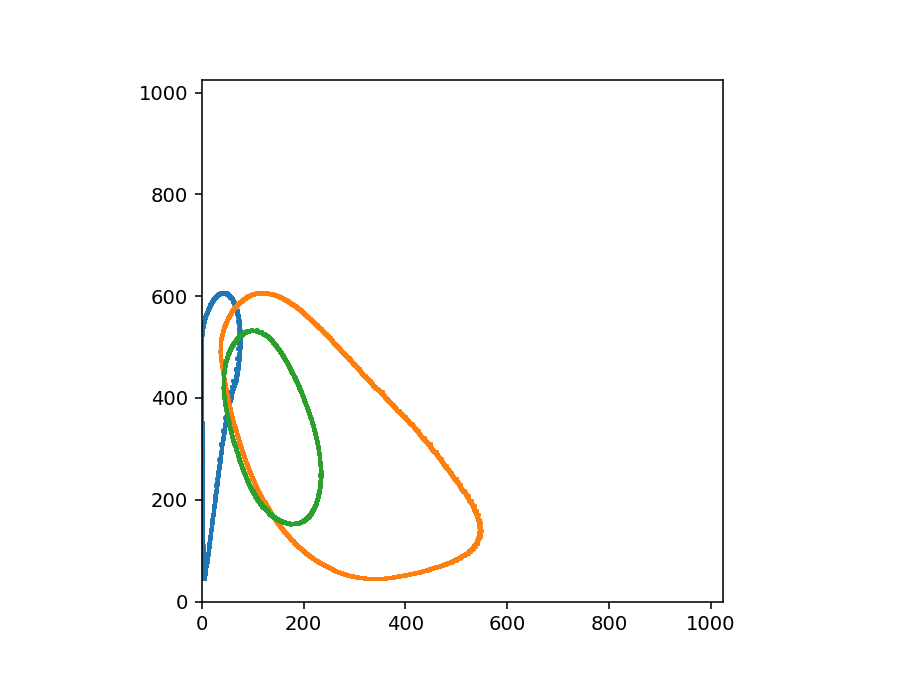

In [79]:
%matplotlib notebook
fig, ax = plt.subplots(dpi=141)
xhi = nbins
xlo = 0
ax.set_xlim(xlo, xhi)
ax.set_ylim(xlo, xhi)

ax.set_aspect(1)
fig.canvas.draw()
s = max(1,((ax.get_window_extent().width  / (xhi-xlo+1.) *72./fig.dpi) ** 2))  

for i in range(len(RCs)):
    plt.scatter((np.array(RCs[i])[:,0]-delta),(np.array(RCs[i])[:,1]-delta), s=s, marker='s', label=i+1)
plt.show()

<IPython.core.display.Javascript object>


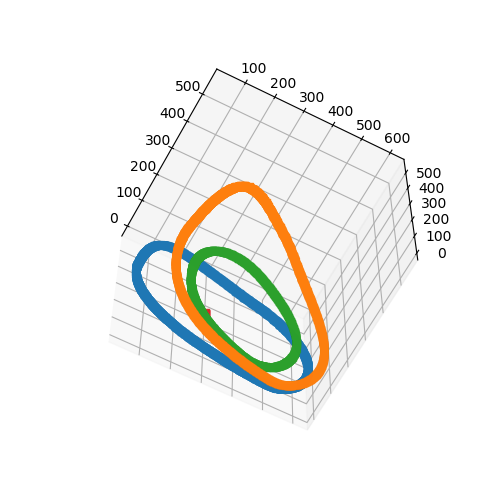

In [80]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(RCs)):
    ax.scatter((np.array(RCs[i])[:,0]-delta),(np.array(RCs[i])[:,1]-delta), (np.array(RCs[i])[:,2]-delta), marker='s', label=i+1)
plt.show()

In [74]:
RCs = cds.get_recurrent_components(includeselfedges=True)

RPcubes = {}

for i in range(0,len(RCs)):#range(0,1)
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(RCs[i])
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    Nbhd = RPcubes[i][0]
    print("Finding isolated nbhd")
    S = cds.invariantPart(Nbhd)
    M = cds.cubical_wrap(S).intersection(cds.G.nodes())
#     for mstep in range(1):
#         M = cds.cubical_wrap(M).intersection(cds.G.nodes())
    
    #calculate index pair
    try:
        print("Calculating index pair")
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        print("Calculating homology")
        
#         proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_map.map'%(i+1)],stdout=subprocess.PIPE)
        proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
#         proc = subprocess.Popen(['homcubes', '-i',
#                                  'rc%s_P1_map.map'%(i+1), 
#                                  'rc%s_P1_cubes.cub'%(i+1),
#                                  'rc%s_P0_cubes.cub'%(i+1)], stdout=subprocess.PIPE)

        linenum = 0
#         print(proc.stdout.readlines())
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            print("           "+line.rstrip().decode('UTF-8'))
#             if line.rstrip().decode('UTF-8')[0] in ['H', '	', 'D', 'F'] and not line.rstrip().decode('UTF-8')[1] == 'O':
# #             if line.rstrip().decode('UTF-8')[0:2] == 'H_' or line.rstrip().decode('UTF-8')[0:2] == '  ' or line.rstrip().decode('UTF-8')[0:2] == 'Di':
                
#                 print("           "+line.rstrip().decode('UTF-8'))
#             linenum+=1
            
    except Exception as e:
        if e=='too many values to unpack (expected 4)':
            print('Faile')
        else:
            print(e)

Component 1
Finding isolated nbhd
Calculating index pair
Calculating homology
           HOMCUBES, ver. 3.07, 09/25/15. Copyright (C) 1997-2015 by Pawel Pilarczyk.
           This is free software. No warranty. Consult 'license.txt' for details.
           Note: The empty file 'rc1_P0_cubes.cub' is assumed to contain cubes.
           Reading cubes to X from 'rc1_P1_cubes.cub'... 4229 cubes read.
           Reading cubes to A from 'rc1_P0_cubes.cub'... 0 cubes read.
           200000 bit fields allocated (2 MB) to speed up 4-dimensional reduction.
           Reducing full-dim cubes from X... .               3       7      11      14      18      22      26      29      33      37      410*               3       7      11      1492507 removed, 1722 left.
           2578 bit fields for dimension 4 were used.
           Transforming X into cells... 1722 cells added.
           Collapsing faces in X... .... 111490 removed, 11069 left.
           Note: The dimension of X decreased from 4 to

Calculating index pair
too many values to unpack (expected 4)
Component 24
Finding isolated nbhd
Calculating index pair
Calculating homology
           HOMCUBES, ver. 3.07, 09/25/15. Copyright (C) 1997-2015 by Pawel Pilarczyk.
           This is free software. No warranty. Consult 'license.txt' for details.
           Reading cubes to X from 'rc24_P1_cubes.cub'... 2 cubes read.
           Reading cubes to A from 'rc24_P0_cubes.cub'... 1 cubes read.
           Computing X\A... 1 cubes removed from X, 1 left.
           Restricting A to the neighbors of X\A... 0 cubes removed, 1 left.
           200000 bit fields allocated (2 MB) to speed up 4-dimensional reduction.
           Expanding A in X... 1 cubes moved to A, 0 left in X\A.
           Restricting A to the neighbors of X\A... 2 cubes removed, 0 left.
           There are no cubes left in X\A. The homology of (X,A) is trivial.
           Thank you for using this software. We appreciate your business.
Component 25
Finding isolated nb